In [111]:
from IPython.display import Markdown, Latex, display
import datetime
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [112]:
import rasterio
import shapely
from rasterio.features import shapes
from rasterio.mask import mask

def get_load_gdf(vuelo, z):
    carga = {1: 1.5, 2:7.5, 3: 5, 4: 30, 5: 7, 6: 12.5, 7: 12.5, 9: 8}
    ds = rasterio.open(f'FINALES/FM/fm_{vuelo}_zona{z}.tif')
    s = shapes(rasterio.band(ds, 1))
    
    g = list(s)
    
    geom = [shapely.geometry.shape(i[0]) for i in g]
    geom = gpd.GeoSeries(geom, crs=ds.crs)
    geom
    
    values = [int(i[1]) for i in g]
    values = pd.Series(values)
    
    result = gpd.GeoDataFrame({'vuelo': vuelo, 'modelo': values, 'geometry': geom})
    result = result[result.modelo > 0]
    
    result['area'] = result.apply(lambda x: x.geometry.area / 10_000, axis=1)
    result = result[['modelo', 'vuelo', 'area']].groupby(['modelo', 'vuelo']).sum().reset_index()
    result['carga'] = result.apply(lambda x: x.area * carga[x.modelo], axis=1)
    
    return result

In [113]:
vuelos_texto = {
    'lida2': 'IGN2017',
    'lida3': 'IGN2024',
    'vuelo1': 'Vuelo1',
    'vuelo2': 'Vuelo2'}

In [114]:
fechas_vuelos = {'lida2': datetime.datetime(2017, 10, 10), 
          'vuelo1': datetime.datetime(2024, 8, 23),  
          'lida3': datetime.datetime(2024, 9, 1), 
          'vuelo2': datetime.datetime(2025, 10, 2)}

In [115]:
fechas_vuelos_z3 = {'lida2': datetime.datetime(2017, 10, 10), 
          'lida3': datetime.datetime(2024, 9, 1), 
          'vuelo2': datetime.datetime(2025, 10, 2)}

In [116]:
display('', metadata={
    'tipo': 'portada',
})

''

\tableofcontents \newpage

# SITUACIÓN

Las parcelas de estudio se encuentran localizadas en la cara sur de la sierra de Leyre dentro del municipio de Yesa. Se muestra un mapa con la distrbución de la vegetación:

In [117]:
display('', metadata={
    'tipo': 'imagen',
    'nombre': 'ocupacion_suelo',
    'caption': 'Mapa de vegetación en las parcelas de estudio. Fuente: elaboración propia a partir de datos obtenidos del IDENA'
})

''

En el año 2022 parte de la zona de estudio se vio afectada por un incendio forestal ocurrido el 15 de junio de ese año. Se muestra un mapa de las zonas afectadas por el incendio. La escala de colores representa el grado de severidad del incendio usando la metodología citada en <cite data-cite="dNBR">(dNBR, 2009)</cite> y usando datos del satélite Sentinel 2 de la Agencia Espacial Europea <cite data-cite="Sentinel2">(ESA, 2022)</cite>

In [118]:
display('', metadata={
    'tipo': 'imagen',
    'nombre': 'dNBR',
    'caption': 'Zonas afectadas por el incendio forestal del 2022. Fuente: elaboración propia a partir de imágenes multiespectrales del satélite Sentinel2'
})

''

Se puede observar que el incendio afectó principalmente a la zona 2, pero la severidad del mismo no fue homogénea en todo su territorio. Se muestra detalle de la severidad en esa zona y como se observa una "isla" de color verde en el que el incendio tuvo menos intesidad.

In [119]:
display('', metadata={
    'tipo': 'imagen_duo',
    'img1': 'FINALES/IMAGENES/dNBR_zona2',
    'caption': 'Detalle de la serveridad del incendio en la zona 2. Fuente: elaboración propia a partir de imágenes multiespectrales del satélite Sentinel2'
})

''

# FUENTE DE DATOS Y METODOLOGÍA

Para describir la evolución de la vegetación de los últimos años y observar la afectación de la carga ganadera, los desbroces y el incendio de 2022 se cuentan con 4 fuentes de datos LIDAR:

- Vuelo del Plan Nacional de Ortofotografía Aerea (PNOA) del Instituto Geográfico Nacional realizado en el año 2017 con una resolución de 17 puntos / m². A partir de ahora estos datos se nombrarán como IGN2017 <cite data-cite="PNOA">(PNOA, 2017)</cite>
- Vuelo del Plan Nacional de Ortofotografía Aerea (PNOA) del Instituto Geográfico Nacional realizado en el año 2024 con una resolución de 5 puntos / m². A partir de ahora estos datos se nombrarán como IGN2024 <cite data-cite="PNOA">(PNOA, 2017)</cite>
- Vuelo de agosto de 2024 con una resolución aproximada de 200 puntos / m². A partir de ahora estos datos se nombrarán como Vuelo1
- Vuelo de octubre de 2024 con una resolución aproimada de 200 puntos / m². A partir de ahora estos datos se nombrarán como Vuelo2

Se han utilizado dos métodos para calcular biomasa a partir de datos LIDAR:

- Método basado en los modelos de combustible de Rothermel.
- Fórmula alométrica.

**Método de cálculo de biomasa basado en modelos de combustible de Rothermel**

Para el cálculo de la biomasa se recurre a los modelos de combustible de Rothermel <cite data-cite="Rothermel">(Rothermel, 1972)</cite>. 

Rothermel estableció una serie de modelos de combustible para caracterizar el comportamiento del fuego en un incendio forestal. En total son 13 modelos los cuales están divididos en: 

- Modelos de pasto (1, 2 y 3)
- Modelos de matorral (4, 5, 6 y 7)
- Modelos de hojarasca bajo arbolado (8 y 9)
- Modelos de restos de poda y otras actividades selvícolas (10, 11, 12 y 13).

 A cada uno de los modelos Rothermel le asignó un intervalo de carga de combustible, por ejemplo, al modelo 1 le asigna una carga de combustible de entre 1 y 2 T/ha y al modelo 4 entre 25 y 35 T/ha. Es importante señalar que para el cálculo de este intervalo considera solo la parte de biomasa que va a propagar el fuego. Por ejemplo en el modelo 7, que es un modelo de matorral bajo arbolado solo considera la carga de biomasa del matorral, pues considera que va a ser el agente propagador del fuego. A la hora de hacer nuestros cálculos esto tiene un aspecto negativo y otro positivo; el negativo es que la carga de biomasa estará subestimada para el modelo 7 (puesto que no considera la biomasa que aporta el arbolado), el positivo es que nos dará un cálculo de la biomasa más centrado en la prevención de incendios forestales.

Se muestra a continuación la tabla de modelos de combustible de Rothermel y el intervalo de carga de combustible de cada uno de ellos.

In [120]:
display('', metadata={'tipo': 'tabla_mc'})

''

Para poder aplicar este método de cálculo de biomasa se debe contar con un mapa de modelos de combustible, para ello se usará el método descrito en <cite data-cite="Sol">(Fernández, 2013)</cite>. Se usarán los datos LiDAR descritos anteriormente y se obtendrán 4 mapas de combustible para los 4 momentos en los que se realizaron los vuelos LiDAR. La resolución de estos mapas será de 10 m/pixel. Se calculará la superficie que ocupa cada modelo de combustble y se multiplicará esa superficie por el valor intermedio de intervalo que asigna Rothermel a cada modelo, por ejemplo, para el modelo 1 (1-2 T/ha) se multiplicará por 1.5. Posteriormente se hará el sumatorio de las cargas de cada uno de los modelos de combustible para obtener la carga de biomasa total de la zona.  

**Estimación de biomasa usando ecuaciones alométricas**

Las ecuaciones alométricas permiten hacer estimaciones de valores dificiles de medir como es la biomasa de un arbol a partir de valores más fáciles de medir como el diametro y la altura del mismo. En el caso que nos ocupa se va a estimar la biomasa de las zonas de estudio a partir de los datos LiDAR que se disponen. Para realizar esta estimación se va a usar la siguiente ecuación citada en <cite data-cite="Simoes">(Simoes, 2020)</cite>:

$$AGB_{LIDAR} = 0.36*\mu_z^{1.16}*z_{75}^{0.78}*z_{10}^{-0.18}*k_z^{0.41}$$

Siendo:

- mu: la altura media sobre el terreno de todos los retornos LiDAR
- z_75: El percentil 75 de los retornos
- z-25: El percentil 25 de los retornos
- k: kurtosis de la distribución de retornos.

Para calcular la biomasa de las zonas de estudio se va a dividir dichas zonas en cuadriculas de 10x10 metros a las que se va a aplicar la ecuación. Esta ecuación dará la biomasa para esa cuadrícula medida en kg/m², como las cuadrículas tienen una superficie de 100 m² se tiene que multiplicar por 100 para obtener la biomasa total de la cuadrícula. Se hará el sumatorio de todas las cuadrículas que conforman la zona de estudio para obtener la biomasa total de la zona. Este procedimiento se realizará para cada una de las trez zonas y cada uno de los vuelos de que se dispone. 

# RESULTADOS 

## Método de Rothermel.

Para poder obtener los mapas de combustible se deben obtener los mapas de matorral y arbolado tal y como de describe en <cite data-cite="Sol">(Fernández, 2019)</cite>. El mapa de matorral se obtendrá usando los datos LiDAR y se asignará a cada pixel el valor máximo de todos los retornos de ese pixel clasificados como vegetación y cuya altura respecto al suelo esté entre 0.2 y 3 metros (se omiten los valores de 0 a 0.2 para no incluir retornos que puedan ser ruido). Para el mapa de arbolado se usará el valor máximo de los puntos clasificados como vegetación cuya altura respecto al suelo sea de más de 3 metros. Tanto el mapa de arbolado como de matorral tienen una resolución de 1 m/pixel.

### Zona 1

In [121]:
z = 1
textos = {
    'lida2': 'Se observa predominio de modelo 4, es decir, un matorral alto y denso con gran capacidad de propagar incendios forestales y al que Rothermel le asigna un valor alto de biomasa por unidad de superficie',
    'lida3': 'Similar a los datos del vuelo IGN2024, pero en el histograma se observa un repunte de retornos en capas bajas de vegetación.',
    'vuelo1': 'Se observa una disminución en en el modelo 4 y una aumento de los modelos de pasto 1 y 2, este cambio en la carga de combustible es probable que se deba a los desbroces ejecutados en la zona',
    'vuelo2': 'Se observa un ligero aumento en el porcentage de modelos de matorral (5 y 6) y una disminución de los modelos de pasto'
}

gdf = {}
carga = {}
gdfs = []
for i in list(textos.keys()):
    a = get_load_gdf(i, z)
    gdfs.append(a)

    a.loc['Total', ['area', 'carga']] = a.sum(numeric_only=True, axis=0)

    gdf[i] = a[['modelo', 'area', 'carga']].to_latex(index=False, formatters={'carga': '{:.2f}', 'area': '{:.2f}', 'modelo': '{:.0f}'}, na_rep='Total', column_format='ccc')
    carga[i] = a.loc['Total', 'carga']
    
display('', metadata={'tipo': 'descripcion', 'datos': {
                        'zona': z, 
                        'vuelos': ['lida2', 'vuelo1', 'lida3', 'vuelo2'], 
                        'textos': textos,
                        'gdf': gdf,
                        'carga': carga}})

''

**Análisis de los datos obtenidos para la zona1**

Para analizar la evolución en el tiempo de la biomasa se muestra la siguiente gráfica.

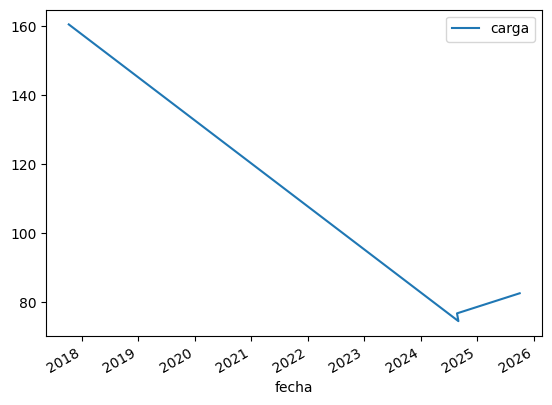

In [122]:
carga_df = pd.DataFrame({'carga': [carga[x] for x in list(textos.keys())], 'fecha': [fechas_vuelos[x] for x in list(textos.keys())]})

fig = carga_df.plot(x='fecha')

Como se puede observar en la gráfica, se muestra una descenso notable de biomasa entre 2017 y 2024, esto es debido a los desbroces realizados, que transformaron zonas de modelo 4 en zonas de modelo de pasto (modelos 1 y 2). En la siguiente tabla se muestra el decrecimiento de biomasa del modelo 4.

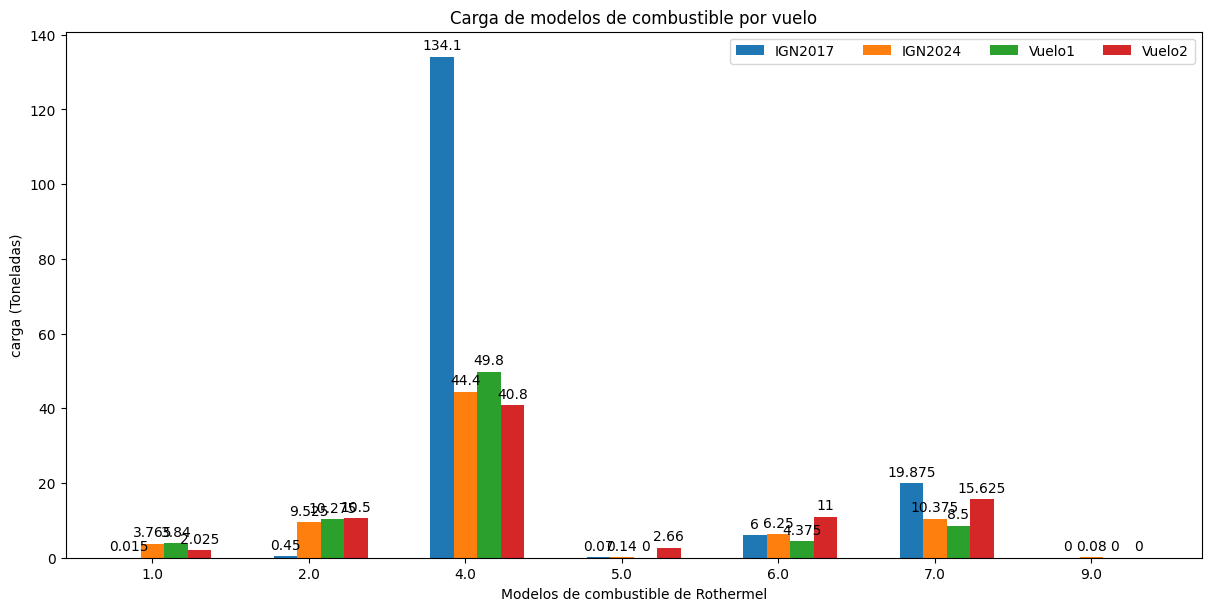

In [123]:
b = pd.concat(gdfs)
b = b[~pd.isna(b.modelo)]

modelos = b.modelo.sort_values().unique()
plot_data = {}
for vuelo in list(textos.keys()):
    plot_data[vuelo] = [b[(b.vuelo == vuelo) & (b.modelo == x)].carga.iloc[0] if len(b[(b.vuelo == vuelo) & (b.modelo == x)]) > 0 else 0 for x in modelos]

x = np.arange(len(modelos))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,6), layout='constrained')

for vuelo, modelo in plot_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, modelo, width, label=vuelos_texto[vuelo])
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('carga (Toneladas)')
ax.set_xlabel('Modelos de combustible de Rothermel')
ax.set_title('Carga de modelos de combustible por vuelo')
ax.set_xticks(x + width, modelos)
ax.legend(loc='upper right', ncols=4)
plt.show()

In [124]:
# b = pd.concat(gdfs)
# b = b[~pd.isna(b.modelo)]
# b = b[b.modelo != 9]

# modelos = b.modelo.sort_values().unique()
# plot_data = {}
# for vuelo in list(textos.keys()):
#     plot_data[vuelo] = [b[(b.vuelo == vuelo) & (b.modelo == x)].carga.iloc[0] if len(b[(b.vuelo == vuelo) & (b.modelo == x)]) > 0 else 0 for x in modelos]

# width = 0.6  # the width of the bars

# fig, ax = plt.subplots(figsize=(8,6), layout='constrained')

# bottom = np.zeros(6)
# for vuelo, modelo in plot_data.items():
#     p = ax.bar(modelos, modelo, width, label=vuelo, bottom=bottom)
#     bottom += modelo

#     ax.bar_label(p, label_type='center')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('carga (Toneladas)')
# ax.set_xlabel('Modelos de combustible de Rothermel')
# ax.set_title('Carga de modelos de combustible por vuelo')
# ax.set_xticks(x + width, modelos)
# ax.legend(loc='upper left', ncols=4)
# plt.show()

### Zona 2

In [125]:
z = 2
textos = {
    'lida2': 'Predominio casi total de modelo 7. Es decir un modelo de matorral bajo arbolado con continuidad vertical. Rothermel le asigna cargas de biomasa por unidad de superficie medias pues considera que es el matorral, principalmente, el que va a propagar el fuego',
    'lida3': 'Similar a los datos de IGN2024, también se observa en el histograma un aumento de retornos en capas bajas de vegetación',
    'vuelo1': 'Debido al incendio de 2022 se observa una disminución drástica en la vegetación lo que se traduce en disminución de modelo 7 y aumento de los modelos de combustible de tipo matorral',
    'vuelo2': 'El incremento de retornos en capas bajas de vegetación en el histograma es más evidente que en el año anterior, pudiendo indicar que la carga ganadera es demasiado baja'
}

gdf = {}
gdfs = []
carga = {}
for i in list(textos.keys()):
    a = get_load_gdf(i, z)
    gdfs.append(a)
    a.loc['Total', ['area', 'carga']] = a.sum(numeric_only=True, axis=0)

    gdf[i] = a[['modelo', 'area', 'carga']].to_latex(index=False, formatters={'carga': '{:.2f}', 'area': '{:.2f}', 'modelo': '{:.0f}'}, na_rep='Total', column_format='ccc')
    carga[i] = a.loc['Total', 'carga']
    
display('', metadata={'tipo': 'descripcion', 'datos': {
                        'zona': z, 
                        'vuelos': ['lida2', 'vuelo1', 'lida3', 'vuelo2'], 
                        'textos': textos,
                        'gdf': gdf,
                        'carga': carga}})

''

**Análisis de los datos obtenidos para la zona2**

Para analizar la evolución en el tiempo de la biomasa se muestra la siguiente gráfica.

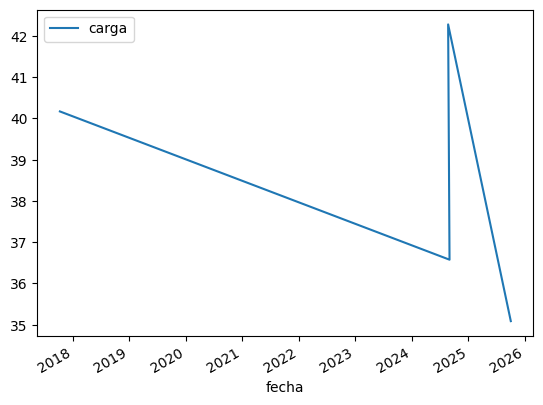

In [126]:
carga_df = pd.DataFrame({'carga': [carga[x] for x in list(textos.keys())], 'fecha': [fechas_vuelos[x] for x in list(textos.keys())]})

fig = carga_df.plot(x='fecha')

Se observa que hay descenso de biomasa, pero este descenso no es muy acusado (alrededor de un 10%) a pesar de que la zona fue afectada por un incendio forestal en el año 2022. Como se comentó en el apartado anterior, una de las deventajas de usar este método de cálculo de la biomasa es que se subestima la biomasa del modelo 7. En la siguiente gráfica se muestra la evolución de este modelo (y del resto) en los diferentes vuelos LiDAR.  

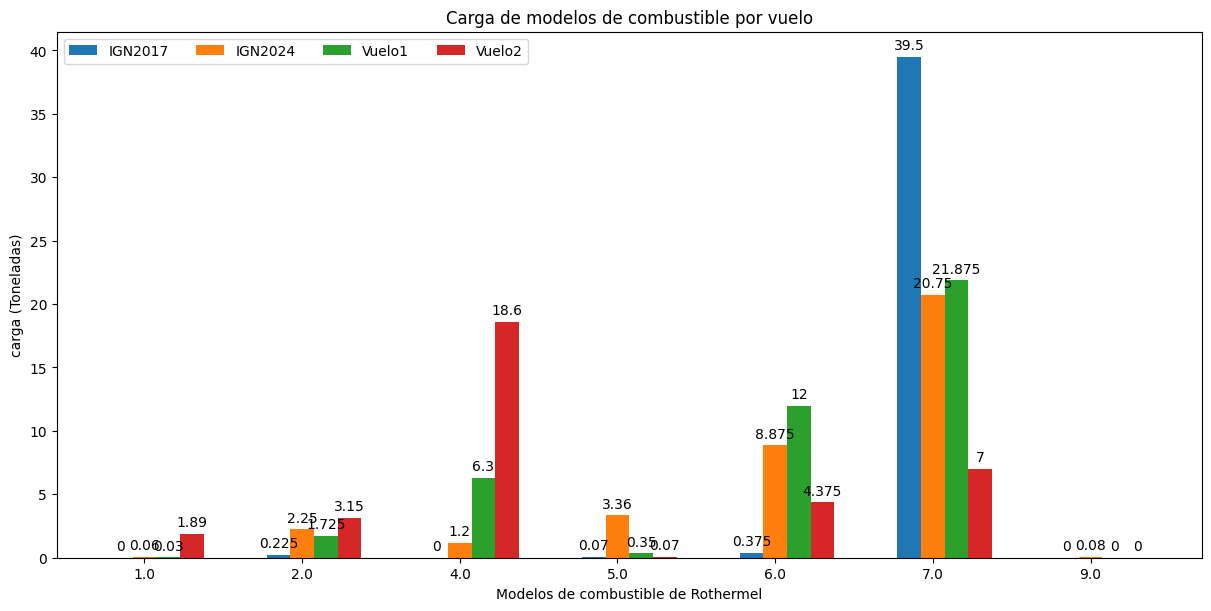

In [127]:
b = pd.concat(gdfs)
b = b[~pd.isna(b.modelo)]

modelos = b.modelo.sort_values().unique()
plot_data = {}
for vuelo in list(textos.keys()):
    plot_data[vuelo] = [b[(b.vuelo == vuelo) & (b.modelo == x)].carga.iloc[0] if len(b[(b.vuelo == vuelo) & (b.modelo == x)]) > 0 else 0 for x in modelos]

x = np.arange(len(modelos))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,6), layout='constrained')

for vuelo, modelo in plot_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, modelo, width, label=vuelos_texto[vuelo])
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('carga (Toneladas)')
ax.set_xlabel('Modelos de combustible de Rothermel')
ax.set_title('Carga de modelos de combustible por vuelo')
ax.set_xticks(x + width, modelos)
ax.legend(loc='upper left', ncols=4)
plt.show()

Como se observa, el modelo 7 sufrió un descenso considerable del 2017 al 2024, posiblemente debido al incendio forestal del 2022. Posteriormente a ese incendio se realizó un resalveo que puso en luz la vegetación de matorral y por consiguiente se produjo un aumento de los modelos de combustible de este tipo. Como se dijo en el apartado anterior, uno de los beneficios de este método es observar la evolución de la vegetación desde una prespectiva de prevención de incendios forestales, en este caso, se observa como la puesta en luz de la vegetación después de un resalveo puede beneficiar a la vegetación con más potencial de arder y propagar incendios forestales (modelo 4).

### Zona 3

In [128]:
z = 3
textos = {
    'lida2': 'Zona muy inflamable con presencia alta de 2 de los modelos más desfavorables para la propagación de un incendio forestal, el modelo 4 y el model 7',
    'lida3': 'En los mapas de vegetación se muestra una disminución de la misma en dos zonas muy concretas de la parcela: zona sur debido a desbroces realizados en 2024 y zona norte debido al incendio forestal de 2022. Eso se traduce en el aumento de modelos de combustible menos favorables para la propagación de un incendio forestal, como los modelos de pasto 1 y 2 y el modelo de matorral de tipo 6',
    'vuelo2': 'Se observa ligero repunte de retorno de capas bajas de vegetación en el histograma'
}

gdf = {}
gdfs = []
carga = {}
for i in list(textos.keys()):
    a = get_load_gdf(i, z)
    gdfs.append(a)
    a.loc['Total', ['area', 'carga']] = a.sum(numeric_only=True, axis=0)

    gdf[i] = a[['modelo', 'area', 'carga']].to_latex(index=False, formatters={'carga': '{:.2f}', 'area': '{:.2f}', 'modelo': '{:.0f}'}, na_rep='Total', column_format='ccc')
    carga[i] = a.loc['Total', 'carga']
    
display('', metadata={'tipo': 'descripcion', 'datos': {
                        'zona': z, 
                        'vuelos': ['lida2', 'lida3', 'vuelo2'], 
                        'textos': textos,
                        'gdf': gdf,
                        'carga': carga}})

''

**Análisis de los datos obtenidos para la zona3**

Para analizar la evolución en el tiempo de la biomasa se muestra la siguiente gráfica.

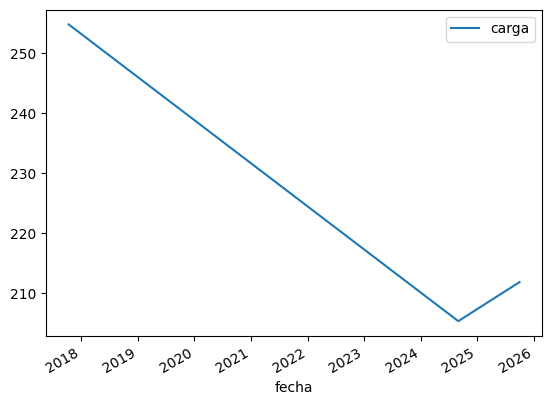

In [129]:
carga_df = pd.DataFrame({'carga': [carga[x] for x in list(textos.keys())], 'fecha': [fechas_vuelos[x] for x in list(textos.keys())]})

fig = carga_df.plot(x='fecha')

Se observa un descenso de biomasa entre 2017 y 2024, muy probablemte debido a los desbroces practicados en la zona, sobretodo en la parte sur de la parcela) y un ligero repunte entre 2024 y 2025. A continuación se muestra la evolución de los modelos de combustible en los 4 vuelos LiDAR:

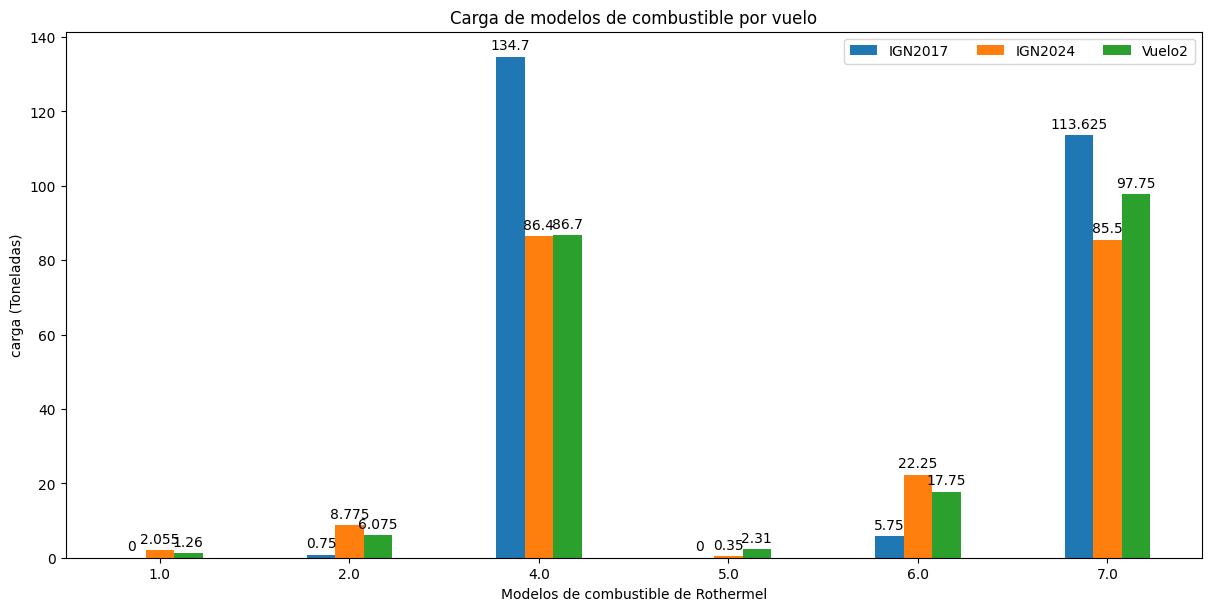

In [130]:
b = pd.concat(gdfs)
b = b[~pd.isna(b.modelo)]

modelos = b.modelo.sort_values().unique()
plot_data = {}
for vuelo in list(textos.keys()):
    plot_data[vuelo] = [b[(b.vuelo == vuelo) & (b.modelo == x)].carga.iloc[0] if len(b[(b.vuelo == vuelo) & (b.modelo == x)]) > 0 else 0 for x in modelos]

x = np.arange(len(modelos))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,6), layout='constrained')

for vuelo, modelo in plot_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, modelo, width, label=vuelos_texto[vuelo])
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('carga (Toneladas)')
ax.set_xlabel('Modelos de combustible de Rothermel')
ax.set_title('Carga de modelos de combustible por vuelo')
ax.set_xticks(x + width, modelos)
ax.legend(loc='upper right', ncols=4)
plt.show()

Se muestra descenso de modelo 4 y ligero aumento de modelos de pasto, esta transformación es muy probablemente debida, como ya se ha comentado, a los desbroces realizados en la zona. 

## Fórmula alométrica

In [131]:
vuelos = {'IGN2017': datetime.datetime(2017, 10, 10), 
          'IGN2024': datetime.datetime(2024, 9, 1), 
          'Vuelo1': datetime.datetime(2024, 8, 23),
          'Vuelo2': datetime.datetime(2025, 10, 2)}

### Zona 1

Se muestra mapa del cálculo de biomasa estimada para cada una de las cuadrículas que conforman la zona 1

In [132]:
z = 1

display('', metadata={
    'tipo': 'imagen_duo',
    'img1': f'BIOMASA/IMAGENES/biomasa_lida2_zona{z}',
    'img2': f'BIOMASA/IMAGENES/biomasa_lida3_zona{z}',
    'caption': f'A la izqda IGN2017 a la dcha IGN2024'
})

''

In [133]:
z = 1

display('', metadata={
    'tipo': 'imagen_duo',
    'img1': f'BIOMASA/IMAGENES/biomasa_vuelo1_zona{z}',
    'img2': f'BIOMASA/IMAGENES/biomasa_vuelo2_zona{z}',
    'caption': f'A la izqda Vuelo1 a la dcha Vuelo2'
})

''

Se puede observar que en general la carga de biomasa es mayor en los datos de Vuelo1 y Vuelo2, esto puede ser debido a una influencia en los resultados del sensor LiDAR usado, hay que recordar que los datos IGN2024 tienen una resolución de 5 retornos/m², muy inferior a los 200 retornos/m² de los datos de Vuelo1 y Vuelo2. 

Se puede observar también en los mapas una carga de biomasa prácticamente nula en las zonas donde se practicaron los desbroces mecanizados. A continuación se adjunta una tabla y una gráfica donde se muestra la evolución de la biomasa en el tiempo. 

\begin{table}[H]
\caption{Biomasa en cada uno de los vuelos expresada en toneladas}
\begin{tabular}{llr}
\toprule
vuelo & fecha & biomasa \\
\midrule
IGN2017 & 10/10/2017 & 72.149445 \\
IGN2024 & 01/09/2024 & 40.576587 \\
Vuelo1 & 23/08/2024 & 93.208569 \\
Vuelo2 & 02/10/2025 & 96.398699 \\
\bottomrule
\end{tabular}
\end{table}


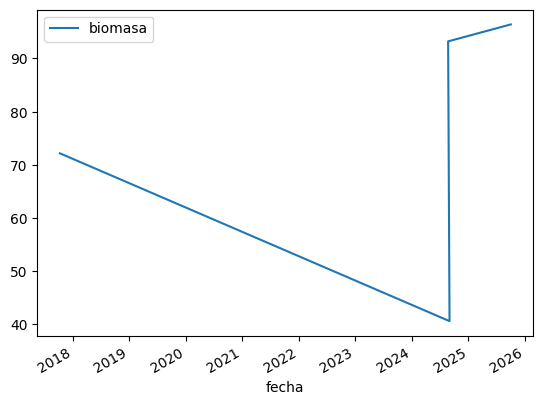

In [134]:
biomasa = []

for vuelo in ['lida2', 'lida3', 'vuelo1', 'vuelo2']:
    gdf = gpd.read_file(f'BIOMASA/SHP/{vuelo.upper()}_ZONA{z}')
    biomasa.append(gdf['agb'].sum())

df = pd.DataFrame({'vuelo': vuelos.keys(), 'fecha': vuelos.values(), 'biomasa': biomasa})
df['biomasa'] = df.apply(lambda x: x.biomasa / 10, axis=1)

display(Markdown(df.to_latex(index=False, formatters={'fecha': '{:%d/%m/%Y}'}, caption='Biomasa en cada uno de los vuelos expresada en toneladas', position='H')))
ax = df.plot(x='fecha')

Se puede observar una subestimación de la biomasa en el vuelo IGN2024. Esto, como ya se ha comentado, puede ser debido a una influencia del sensor LiDAR usado.

### Zona 2

Se muestra mapa del cálculo de biomasa estimada para cada una de las cuadrículas que conforman la zona 2

In [135]:
z = 2

display('', metadata={
    'tipo': 'imagen_duo',
    'img1': f'BIOMASA/IMAGENES/biomasa_lida2_zona{z}',
    'img2': f'BIOMASA/IMAGENES/biomasa_lida3_zona{z}',
    'caption': f'A la izqda IGN2017 a la dcha IGN2024'
})

''

In [136]:
z = 2

display('', metadata={
    'tipo': 'imagen_duo',
    'img1': f'BIOMASA/IMAGENES/biomasa_vuelo1_zona{z}',
    'img2': f'BIOMASA/IMAGENES/biomasa_vuelo2_zona{z}',
    'caption': f'A la izqda Vuelo1 a la dcha Vuelo2'
})

''

Se muestra una disminución de la biomasa a lo largo del tiempo. La tabla y gráfica siguiente lo corroboran.

\begin{table}[H]
\caption{Biomasa en cada uno de los vuelos expresada en toneladas}
\begin{tabular}{llr}
\toprule
vuelo & fecha & biomasa \\
\midrule
IGN2017 & 10/10/2017 & 162.277239 \\
IGN2024 & 01/09/2024 & 97.683977 \\
Vuelo1 & 23/08/2024 & 75.567945 \\
Vuelo2 & 02/10/2025 & 68.465645 \\
\bottomrule
\end{tabular}
\end{table}


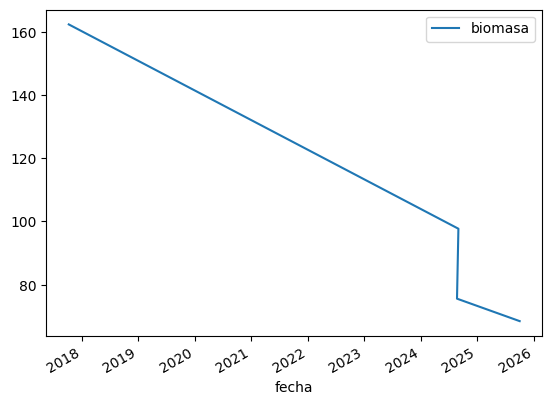

In [137]:
biomasa = []

for vuelo in ['lida2', 'lida3', 'vuelo1', 'vuelo2']:
    gdf = gpd.read_file(f'BIOMASA/SHP/{vuelo.upper()}_ZONA{z}')
    biomasa.append(gdf['agb'].sum())

df = pd.DataFrame({'vuelo': vuelos.keys(), 'fecha': vuelos.values(), 'biomasa': biomasa})
df['biomasa'] = df.apply(lambda x: x.biomasa / 10, axis=1)

display(Markdown(df.to_latex(index=False, formatters={'fecha': '{:%d/%m/%Y}'}, caption='Biomasa en cada uno de los vuelos expresada en toneladas', position='H')))
ax = df.plot(x='fecha')

### Zona 3

Se muestra mapa del cálculo de biomasa estimada para cada una de las cuadrículas que conforman la zona 3

In [138]:
vuelos_z3 = {'IGN2017': datetime.datetime(2017, 10, 10), 
          'IGN2024': datetime.datetime(2024, 9, 1), 
          'vuelo2': datetime.datetime(2025, 10, 2)}

In [139]:
z = 3

display('', metadata={
    'tipo': 'imagen_duo',
    'img1': f'BIOMASA/IMAGENES/biomasa_lida2_zona{z}',
    'img2': f'BIOMASA/IMAGENES/biomasa_lida3_zona{z}',
    'caption': f'A la izqda IGN2017 a la dcha IGN2024'
})

''

In [140]:
z = 3

display('', metadata={
    'tipo': 'imagen_duo',
    'img1': f'BIOMASA/IMAGENES/biomasa_vuelo2_zona{z}',
    'caption': f'Vuelo2'
})

''

En la zona sur de la parcela se aprecia la reducción de biomasa debido a los desbroces mecanizados y al igual que en la zona 1 se muestra una subestimación de biomasa en los datos de IGN2024. Esto se corrobora con los datos de la tabla y gráfica siguiente, donde se muestran los datos de biomasa total, medido en toneladas,  en cada vuelo. 

\begin{table}[H]
\caption{Biomasa en cada uno de los vuelos expresada en toneladas}
\begin{tabular}{llr}
\toprule
vuelo & fecha & biomasa \\
\midrule
IGN2017 & 10/10/2017 & 297.246134 \\
IGN2024 & 01/09/2024 & 153.754563 \\
vuelo2 & 02/10/2025 & 319.153095 \\
\bottomrule
\end{tabular}
\end{table}


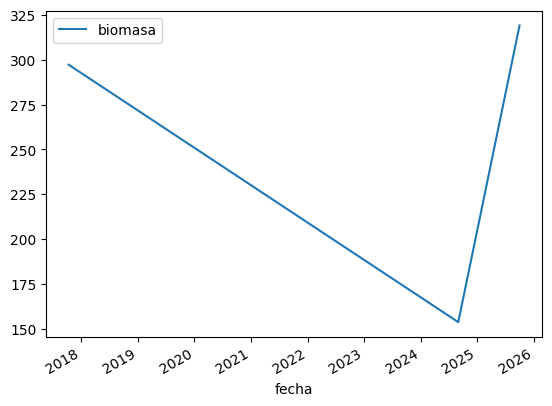

In [141]:
biomasa = []

for vuelo in ['lida2', 'lida3', 'vuelo2']:
    gdf = gpd.read_file(f'BIOMASA/SHP/{vuelo.upper()}_ZONA{z}')
    biomasa.append(gdf['agb'].sum())

df = pd.DataFrame({'vuelo': vuelos_z3.keys(), 'fecha': vuelos_z3.values(), 'biomasa': biomasa})
df['biomasa'] = df.apply(lambda x: x.biomasa / 10, axis=1)

display(Markdown(df.to_latex(index=False, formatters={'fecha': '{:%d/%m/%Y}'}, caption='Biomasa en cada uno de los vuelos expresada en toneladas', position='H')))
ax = df.plot(x='fecha')

## Perfil de nube de puntos

Para analizar la influencia de la carga ganadera en las zonas de desbroce, se ha optado por realizar un perfil de la nube de puntos y ver la evolución de esa zona en el tiempo. Los resultados para cada zona se muestran a continuación.

### Zona 1

Se muestra un mapa de la localización del transecto donde se va a levantar la nube de puntos. Se ha elegido este transecto puesto que corta a las zonas donde se ha realizado desbroce mecanizado

In [142]:
z = 1

display('', metadata={
    'tipo': 'imagen',
    'nombre': f'ZONA{z}/localizacion_transecto',
    'caption': f'Localización del perfil de nube de puntos dentro de la zona {z}'
})

''

A continuación se muestran los perfiles de nubes de puntos para cada uno de los vuelos LiDAR:

In [143]:
z = 1
vuelos = ['lida2', 'lida3', 'vuelo1', 'vuelo2']

display('', metadata={
    'tipo': 'imagen_transecto',
    'nombres': [f'ZONA{z}/transecto_{vuelo}_zona{z}' for vuelo in vuelos]
})

''

Se puede apreciar la diferencia de vegetación entre los datos del primer vuelo y los datos de los otros 3 vuelos, en los que se observa zonas desprovistas de vegetación en las zonas donde se ha realizado un desbroce mecánico. En los datos de Vuelo2 no se aprecian puntos de retorno clasificados como vegetación en las zonas de desbroce, por lo que se puede decir que la carga ganadera está ayudando a mantener esa zona desprovista de vegetación y está realizando una labor desde el punto de vista de la prevención de incendios forestales.

### Zona 2

Se muestra un mapa de la localización del transecto donde se va a levantar la nube de puntos. Se ha elegido este transecto puesto que es una de las zonas más afectadas por el incendio de 2022

In [144]:
z = 2

display('', metadata={
    'tipo': 'imagen',
    'nombre': f'ZONA{z}/localizacion_transecto',
    'caption': f'Localización del perfil de nube de puntos dentro de la zona {z}'
})

''

A continuación se muestran los perfiles de nubes de puntos para cada uno de los vuelos LiDAR:

In [145]:
z = 2
vuelos = ['lida2', 'lida3', 'vuelo1', 'vuelo2']

display('', metadata={
    'tipo': 'imagen_transecto',
    'nombres': [f'ZONA{z}/transecto_{vuelo}_zona{z}' for vuelo in vuelos]
})

''

Entre los datos de IGN2017 y los datos de IGN2024 se aprecia claramente la disminución de vegetación debido al incendio de 2022. En los siguientes vuelos se observa que la vegetación sigue creciendo tanto en zonas descubiertas de arbolado como en las cubiertas. Quizás se deba a una carga de ganado insuficiente.

### Zona 3

Se muestra un mapa de la localización del transecto donde se va a levantar la nube de puntos. Se ha elegido este transecto puesto que corta a las zonas donde se ha realizado desbroce mecanizado

In [146]:
z = 3

display('', metadata={
    'tipo': 'imagen',
    'nombre': f'ZONA{z}/localizacion_transecto',
    'caption': f'Localización del perfil de nube de puntos dentro de la zona {z}'
})

''

A continuación se muestran los perfiles de nubes de puntos para cada uno de los vuelos LiDAR:

In [147]:
z = 3
vuelos = ['lida2', 'lida3', 'vuelo2']

display('', metadata={
    'tipo': 'imagen_transecto',
    'nombres': [f'ZONA{z}/transecto_{vuelo}_zona{z}' for vuelo in vuelos]
})

''

Se puede hacer una lectura muy similar a la zona 1. Se oberva una disminución de vegetación entre IGN2017 e IGN2024 y en los dato del Vuelo2 no se observa que haya vuelto a brotar la vegetación en las zonas desbrozadas, quizás debido a la carga ganadera.

# CONCLUSIONES

Se han usado dos metodologías distintas para analizar la evolución de biomasa en 3 parcelas en las que la vegetación ha sufrido una serie de perturbaciones y en las que se ha introducido ganado vacuno. Los datos LiDAR han sido capaces de identificar y cuantificar dichas perturbaciones, si bien es cierto que el valor de la cuantificación depende de la metodología empleada. 

Con los datos mostrados se puede decir que la metodología basada en los modelos de Rothermel sirve para analizar la vegetación desde una prespectiva de prevención de incendios forestales, mientras que la metodología basada en una formula alométrica da un resultado más preciso de la carga de biomasa, aunque hay que destacar que esta metodología es sensible al sensor LiDAR usado (se han obtenido subestimaciones de biomasa con los datos de IGN2024 que usa una resolución de 5 retornos/m²). 